In [1]:
from __future__ import print_function
import cv2
import os.path as osp
import numpy as np

from pycocotools.coco import COCO


class COCODataset(object):

    def __init__(self, data_dir, image_set, year):
        self.name = 'coco_' + year + '_' + image_set
        # name, paths
        self.year = year
        self.image_set = image_set
        self.data_dir = data_dir

        # COCO API
        self.COCO = COCO(self._get_ann_file())
        cats = self.COCO.loadCats(self.COCO.getCatIds())
        self.classes = tuple([c['name'] for c in cats])
        self.num_classes = len(self.classes)
        # e.g: 'person' -> 0, 'toothbrush' -> 79
        self.class_to_ind = dict(zip(self.classes, range(self.num_classes)))
        # e.g: 'person' -> 1, 'toothbrush' -> 90
        self.class_to_coco_cat_id = dict(
            zip([c['name'] for c in cats], self.COCO.getCatIds()))
        # coco' cat_id (1,,90) -> label_id (0,,79)
        self.coco_cat_id_to_class_ind = dict([(self.class_to_coco_cat_id[cls],
                                               self.class_to_ind[cls])
                                              for cls in self.classes])

        self.image_index = self._load_image_set_index()
        self.num_images = len(self.image_index)

        coco_name = image_set + year  # e.g., "val2014"
        self.data_name = coco_name

    def _get_ann_file(self):
        """
        Get the coco's annotation file path
            When image_set is train|val, it's located in annotations/$image_set/instances_$year.json
            When image_set is test, it's located in annotations/test/image_info_$year.json
        Return:
            anno_path (str)
        """
        prefix = 'instances' if self.image_set.find(
            'test') == -1 else 'image_info'
        return osp.join(self.data_dir, 'annotations',
                        prefix + '_' + self.image_set + self.year + '.json')

    def _load_image_set_index(self):
        """
        Load image ids.
        """
        image_ids = self.COCO.getImgIds()
        return image_ids

    def image_at(self, i):
        im_path = self.image_path_at(i)
        im = cv2.imread(im_path)
        return im

    def image_path_at(self, i):
        """
        Return the absolute path to image i in the image sequence.
        """
        return self.image_path_from_index(self.image_index[i])

    def image_path_from_index(self, index):
        """
        Construct an image path from the image's "index" identifier.
        """
        # Example image path for index=119993:
        #   train2014/COCO_train2014_000000119993.jpg
        image = self.COCO.loadImgs(index)[0]
        image_path = osp.join(
            self.data_dir, self.data_name, image['file_name'])
        assert osp.exists(
            image_path), 'Path does not exist: {}'.format(image_path)
        return image_path

    def gt_bag_labels(self):
        if hasattr(self, '_gt_bag_labels'):
            return self._gt_bag_labels
        self._gt_bag_labels = np.asarray([self._load_coco_annotation(index)
                                          for index in self.image_index], dtype=np.int16)
        return self._gt_bag_labels

    def _load_coco_annotation(self, index):
        annIds = self.COCO.getAnnIds(imgIds=index, iscrowd=None)
        objs = self.COCO.loadAnns(annIds)
        bag_labels = np.zeros(self.num_classes)
        for obj in objs:
            cls = self.coco_cat_id_to_class_ind[obj['category_id']]
            bag_labels[cls] = 1
        return bag_labels

In [2]:
%matplotlib inline

loading annotations into memory...
Done (t=9.80s)
creating index...
index created!
Test index:  1
image path:  /home/lkk/datasets/coco2014/train2014/COCO_train2014_000000384029.jpg
labels:  ['person', 'donut', 'cake']


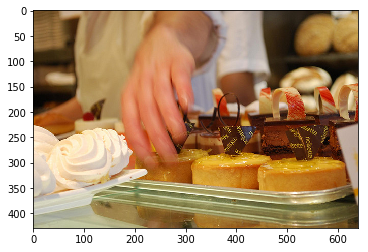

In [3]:

import matplotlib.pyplot as plt
coco = COCODataset(
    '/home/lkk/datasets/coco2014', 'train', '2014')
idx = 1
print('Test index: ', idx)
print('image path: ', coco.image_path_at(idx))
gt_bag_labels = coco.gt_bag_labels()
print('labels: ', [coco.classes[i]
                   for i in range(80) if gt_bag_labels[idx, i]])
image = coco.image_at(idx)
plt.imshow(image[:, :, (2, 1, 0)])
plt.show()


In [17]:
image.min(),image.max()

(0, 255)

In [8]:
import cv2
import numpy as np


def im_to_blob(im):
    im = cv2.resize(im, (224, 224)).astype(np.float32)
    im[:, :, 0] -= 103.939
    im[:, :, 1] -= 116.779
    im[:, :, 2] -= 123.68
    blob = im.transpose((2, 0, 1))
    return blob


class COCODataLayer(object):
    def __init__(self, dataset, batch_size=32):
        """
        Attibutes:
            dataset (COCODataset):
                dataset from which to load the data.
            batch_size (int):
                how many samples per batch to load
        """
        self.dataset = dataset
        self.batch_size = batch_size

        self.num_images = self.dataset.num_images
        self.data_y = self.dataset.gt_bag_labels()
        self.cur = 0
        self.perm = np.random.permutation(np.arange(self.num_images))

    def _shuffle_roidb_inds(self):
        """Randomly permute the training roidb."""
        self.perm = np.random.permutation(np.arange(self.num_images))
        self.cur = 0

    def _get_next_minibatch_inds(self):
        """Return the roidb indices for the next minibatch."""
        if self.cur + self.batch_size >= self.num_images:
            self._shuffle_roidb_inds()
        db_inds = self.perm[self.cur:self.cur + self.batch_size]
        self.cur += self.batch_size
        return db_inds

    def _get_next_minibatch(self):
        """
        Retrun:
            data_x: num_bag x 3(c) x 224(h) x 224(w)
            data_y: num_bag x 80
        """
        data_x = np.zeros((self.batch_size, 3, 224, 224), dtype=np.float32)
        data_y = np.zeros((self.batch_size, self.dataset.num_classes), dtype=np.float32)
        db_inds = self._get_next_minibatch_inds()
        for i, db_ind in enumerate(db_inds):
            im = self.dataset.image_at(db_ind)
            blob = im_to_blob(im)
            data_x[i] = blob
            data_y[i] = self.data_y[db_ind]
        return data_x, data_y

    def get_data(self, start, end):
        end = min(end, self.num_images)
        num_bag = end - start
        data_y = self.dataset.gt_bag_labels()[start: end]
        data_x = np.zeros((num_bag, 3, 224, 224))
        for i in range(start, end):
            im = self.dataset.image_at(i)
            blob = im_to_blob(im)
            data_x[i - start] = blob
        return data_x, data_y

    def generate(self):
        """
        This function is used for keras.Model.fit_generator
        """
        self.cur = 0
        while 1:
            x, y = self._get_next_minibatch()
            yield (x, y)

In [10]:

coco = COCODataset('/home/lkk/datasets/coco2014', 'train', '2014')
data_layer = COCODataLayer(coco)
(x_train, y_train) = data_layer.generate().__next__()
print(x_train.shape)
print(y_train.shape,y_train)


loading annotations into memory...
Done (t=11.48s)
creating index...
index created!
(32, 3, 224, 224)
(32, 80) [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
x_train.max(),x_train.min()

(151.061, -123.68)

In [19]:
from torchvision.datasets import CocoDetection
train_loader = CocoDetection('/home/lkk/datasets/coco2014/train2014',\
    '/home/lkk/datasets/coco2014/annotations/instances_train2014.json')

loading annotations into memory...
Done (t=11.55s)
creating index...
index created!


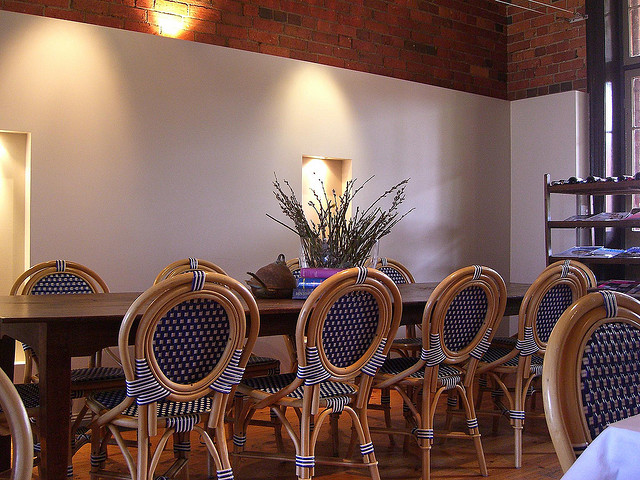

In [21]:
train_loader[0][0]

In [22]:
import json

In [23]:
with open('./vocab.json','r') as j:
    f=json.load(j)

In [34]:
with open('attr.txt','a') as j:
    for k,v in f['word_map'].items():
        #print(k,v)
        j.write(k+'\n')
        #break

In [28]:
type(f['word_map'])

dict